In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib
from openpyxl import load_workbook
from imblearn.over_sampling import SMOTE
from collections import Counter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [4]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Velocidade Final'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Velocidade Final
0,1561.118163,1265.646206,1167.249469,1677.640307,2112.956428,NaN,85.014606,110.083747,0.445369,NaN,...,NaN,NaN,NaN,NaN,NaN,45.267951,39.051027,4.890493,8.125734,1
1,1353.642069,1325.068263,1218.350217,339.272891,1846.996203,527.421515,113.024809,148.298659,0.400038,0.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1320.994042,1302.132063,1261.765524,1425.463392,1864.193278,503.697563,83.507934,127.669590,0.417494,0.564572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1529.765381,1266.266979,1162.386287,1728.364004,2114.092804,NaN,91.580837,113.147145,0.447466,NaN,...,NaN,NaN,NaN,NaN,NaN,40.524918,41.235969,10.094287,10.519589,1
4,1413.415281,1457.404350,1297.960258,1515.937134,1815.764358,NaN,99.216510,132.864330,0.443812,NaN,...,NaN,NaN,NaN,NaN,NaN,43.566213,NaN,6.249735,NaN,1


In [5]:
# Linha a ser adicionada
linha = "1380,0000/ 1300/ 1190,0000/ 1551,7200/ 1880/ 469,6/ 114,32/ 86,58/ 0,432/ 0,519/ 629,4/ 788,8/ 189,6000/ 170/ 62/ 22,0000/ 0/ 0/ 245/ 62/ 22/ 0/ 0/ 2/ 69,4/6,8000/ 15/ 39/ 370,3/ 81/ 180/ 52/ 160,0000/ 7,0800/ 20,7/ 38/ 9,5/ 2080/ 30/ 6,4699/ 8,7287/ 3,6/ 0/ 0/ 43/ 41/ 4,2/ 4,4/ 5/"

# Separar os valores da linha
valores = linha.split("/")

# Converter os valores para float
valores_float = [float(valor.replace(",", ".")) for valor in valores[:-1]]

# Adicionar a nova linha ao final do DataFrame existente
df.loc[len(df)] = valores_float

# Verificar o DataFrame atualizado
print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1561.118163          1265.646206         1167.249469  1677.640307   
1       1353.642069          1325.068263         1218.350217   339.272891   
2       1320.994042          1302.132063         1261.765524  1425.463392   
3       1529.765381          1266.266979         1162.386287  1728.364004   
4       1413.415281          1457.404350         1297.960258  1515.937134   
...             ...                  ...                 ...          ...   
996             NaN                  NaN                 NaN          NaN   
997     1514.746926          1247.188411         1239.870220  1530.101793   
998     1536.400514          1246.464603         1222.534523  1548.878181   
999             NaN                  NaN                 NaN          NaN   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento  DP_Altura do CG com relacao ao chao  MV_Eixo dianteir

In [6]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DP_Altura do CG com relacao ao chao',
    'DMV_Lado Direito',
    'ST_Curso Positivo de projeto',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal',
    'CD_Ganho de arfagem em desaceleracao longitudinal'
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [7]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 21 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   MV_Eixo dianteiro                                        954 non-null    float64
 1   MV_Eixo Traseiro                                         954 non-null    float64
 2   DMV_Dianteira                                            954 non-null    float64
 3   PCG_X                                                    954 non-null    float64
 4   PCG_Y                                                    1001 non-null   float64
 5   PCG_Z                                                    954 non-null    float64
 6   SD_Dimensoes dos pneus                                   1001 non-null   float64
 7   SD_Cambagem estatica                                     191 non-null    float64
 8   SD_Convergência estatica    

In [8]:
#Descrição de dados
df.describe()

,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,SD_Dimensoes dos pneus,SD_Cambagem estatica,SD_Convergência estatica,ST_Dimensoes dos pneus,...,ST_Convergência estatica,MT_Potência maxima do motor,MT_Torque maximo do motor,MT_Relacao total_max,MT_Relacao total_min,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Velocidade Final
count,954.000000,954.000000,954.000000,954.000000,1001.000000,954.000000,1001.000000,191.000000,161.000000,1001.000000,...,142.000000,235.000000,235.000000,928.000000,916.000000,546.000000,434.000000,432.000000,371.000000,1001.000000
mean,73.975169,104.087681,0.414660,304.206011,187.368494,-2984.690045,4.920080,-0.115020,-0.031773,4.932068,...,-0.026187,6.936271,19.010940,28.719060,5.844919,51.601413,48.845013,6.822599,7.463484,3.001998
std,12.005004,13.806419,0.025871,241.598603,235.511706,18843.734947,9.205086,0.460369,0.338379,9.225258,...,0.515354,0.487345,1.399774,5.773015,1.288737,5.059411,5.336009,3.855454,4.144685,1.415626
min,46.099180,75.340037,0.320582,-285.825883,-91.146183,-170275.145241,0.000000,-2.000000,-1.500000,0.000000,...,-2.000000,5.128549,13.858984,3.218078,0.434634,40.023765,25.937922,3.120611,3.743953,1.000000
25%,66.005821,95.712715,0.400152,97.359362,0.016737,154.332557,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.694322,18.576807,26.260453,5.023783,47.564938,45.073813,4.324748,4.669316,2.000000
50%,71.672658,103.524354,0.417255,251.906228,55.786781,251.266555,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.025904,18.803010,28.320194,5.768929,51.935058,49.227319,5.514139,6.119896,3.000000
75%,80.590651,110.721890,0.432226,507.270068,370.399957,419.924218,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.258919,19.562065,31.527264,6.647643,55.434763,52.494674,8.074598,8.520433,4.000000
max,129.610673,169.417592,0.479365,890.686718,984.006876,1015.095842,23.000000,1.970871,1.049839,23.000000,...,2.846394,7.780000,23.000000,53.838854,9.728585,70.679296,61.815220,28.545824,26.970978,5.000000


In [9]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.")    

'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 12.
'PCG_Z' tem 0.
'SD_Dimensoes dos pneus' tem 778.
'SD_Cambagem estatica' tem 157.
'SD_Convergência estatica' tem 142.
'ST_Dimensoes dos pneus' tem 778.
'ST_Cambagem estatica' tem 147.
'ST_Convergência estatica' tem 128.
'MT_Potência maxima do motor' tem 0.
'MT_Torque maximo do motor' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em asfalto ' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em asfalto' tem 0.
'CD_Tempo para atingir velocidade maxima em terra batida' tem 0.
'P_Velocidade Final' tem 0.


## Limpeza

In [10]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 700 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

MV_Eixo dianteiro                                           47
MV_Eixo Traseiro                                            47
DMV_Dianteira                                               47
PCG_X                                                       47
PCG_Y                                                        0
PCG_Z                                                       47
SD_Dimensoes dos pneus                                       0
ST_Dimensoes dos pneus                                       0
MT_Relacao total_max                                        73
MT_Relacao total_min                                        85
CD_Velocidade maxima de 0 a 100 metros em asfalto          455
CD_Velocidade maxima de 0 a 100 metros em terra batida     567
CD_Tempo para atingir velocidade maxima em asfalto         569
CD_Tempo para atingir velocidade maxima em terra batida    630
P_Velocidade Final                                           0
dtype: int64

In [11]:
# Pela análise dos dados se percebe que as colunas de Dimensões de Pneus trazem muitos valores zerados
df = df.drop(['SD_Dimensoes dos pneus'], axis=1)
df = df.drop(['ST_Dimensoes dos pneus'], axis=1)

In [12]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([805, 809, 811, 817, 820, 830, 838, 848, 854, 866, 867, 876, 878,
            881, 889, 890, 891, 898, 905, 912, 916, 919, 928, 935, 936, 938,
            941, 944, 945, 948, 956, 959, 960, 961, 968, 973, 975, 979, 980,
            984, 985, 987, 990, 993, 994, 996, 999],
           dtype='int64')
      MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0             85.014606        110.083747       0.445369  485.153288   
1            113.024809        148.298659       0.400038  263.935693   
2             83.507934        127.669590       0.417494    9.740746   
3             91.580837        113.147145       0.447466  217.672428   
4             99.216510        132.864330       0.443812  201.426690   
...                 ...               ...            ...         ...   
992           65.961657         94.776342       0.441930  478.355026   
995           67.831567         94.846483       0.412839   77.704667   
997           58.360257         85.894308 

In [13]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Velocidade Final'] = df['P_Velocidade Final'].replace(mapeamento)

print(df['P_Velocidade Final'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
992     4.0
995     4.0
997     4.0
998     4.0
1000    4.0
Name: P_Velocidade Final, Length: 954, dtype: float64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Velocidade', index=0)

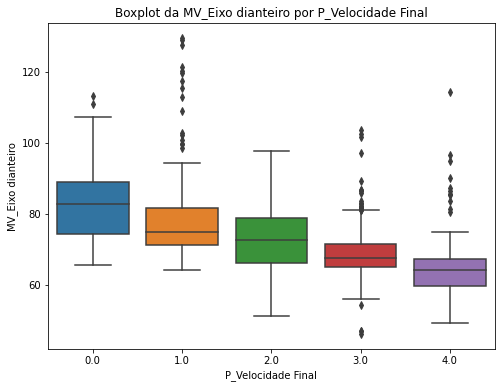

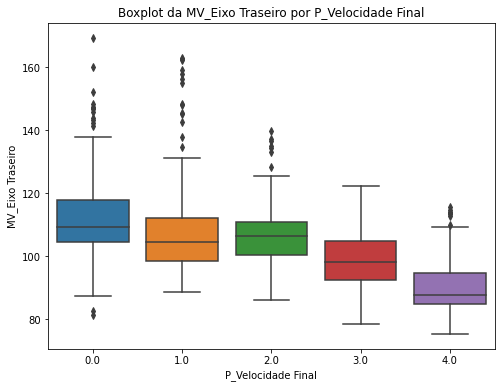

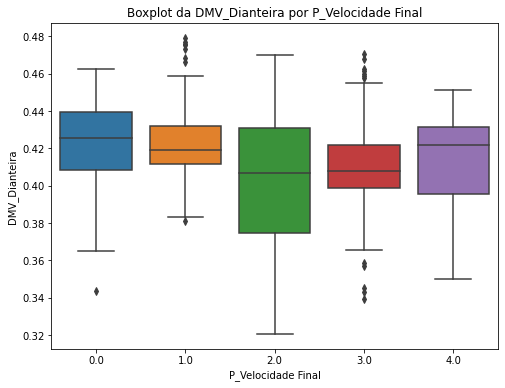

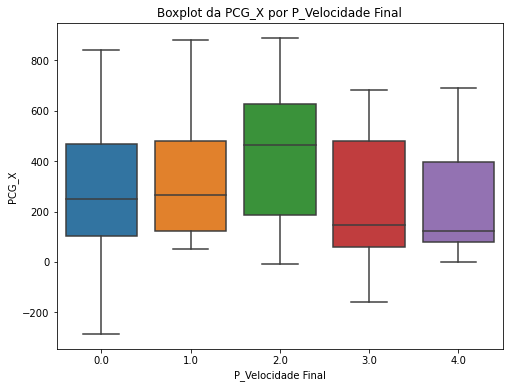

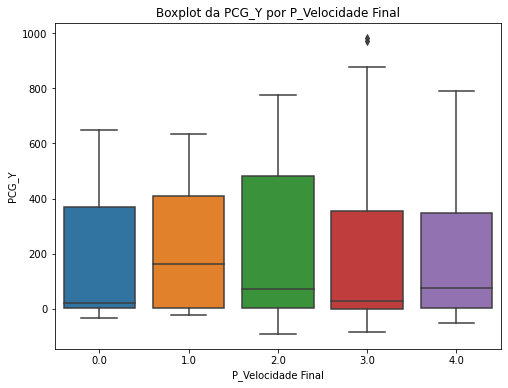

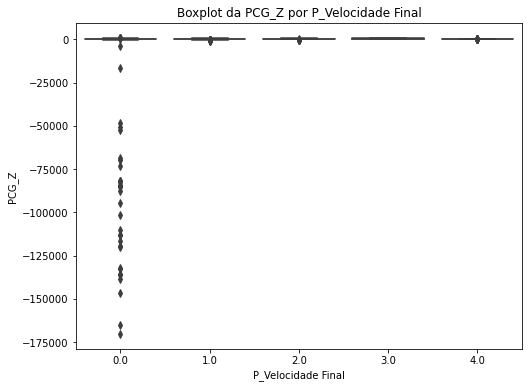

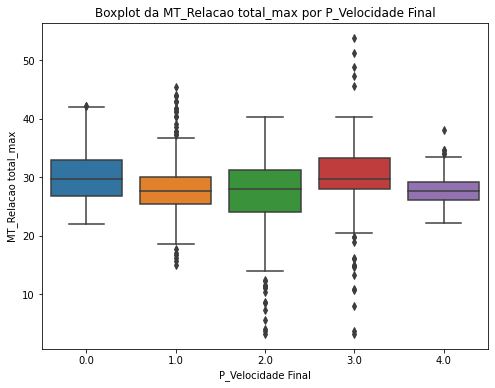

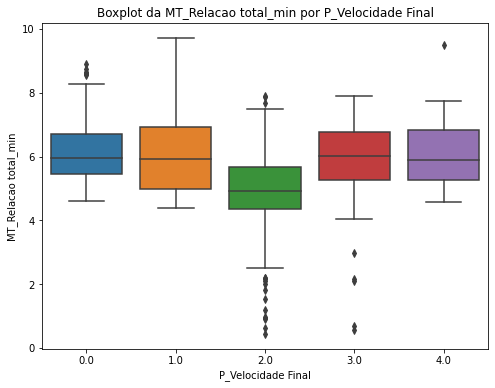

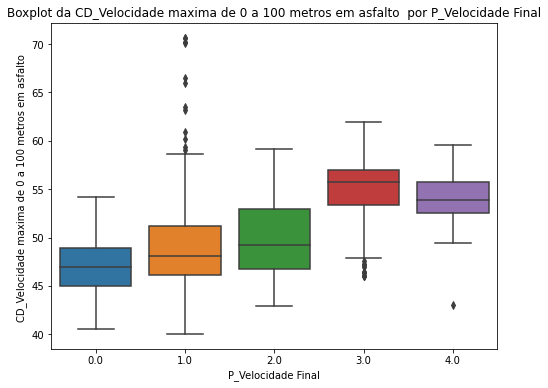

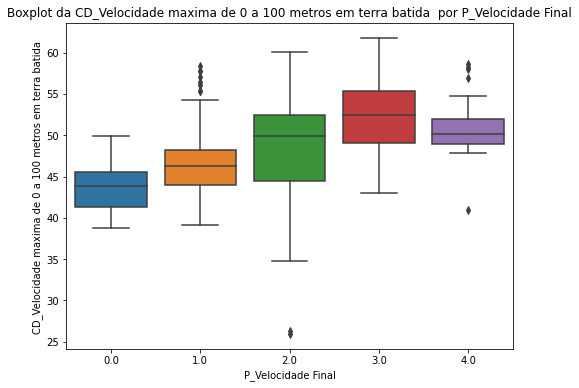

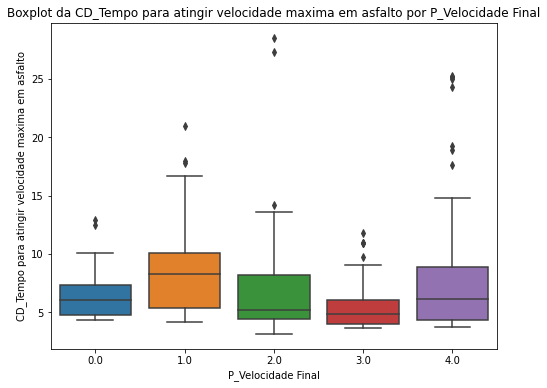

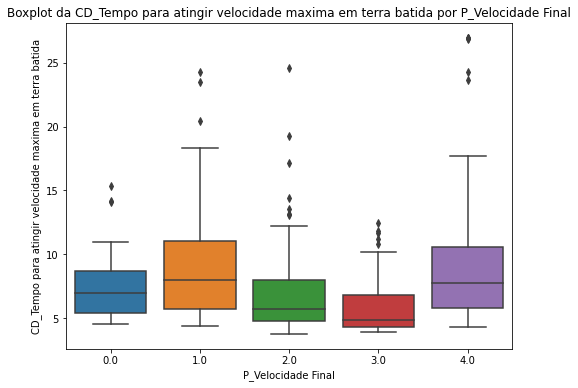

In [14]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Velocidade Final':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Velocidade Final', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Velocidade Final')
        plt.ylabel(coluna)
        plt.xlabel('P_Velocidade Final')
        plt.show()

In [15]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Velocidade Final']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Velocidade Final'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Velocidade Final'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Velocidade Final'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

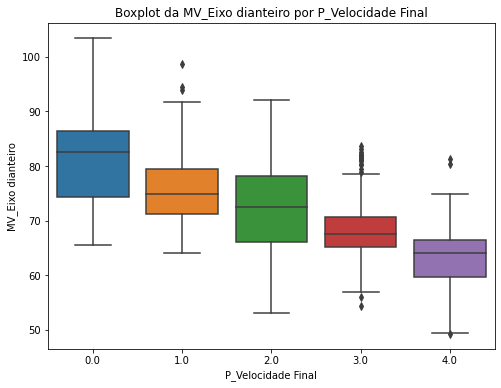

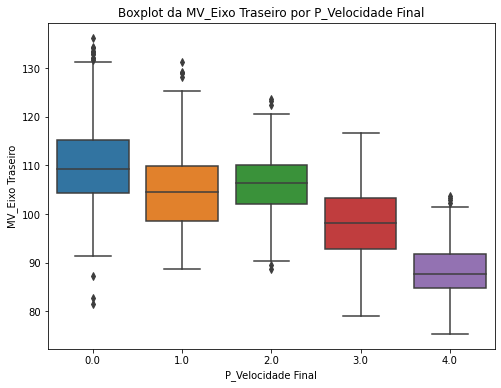

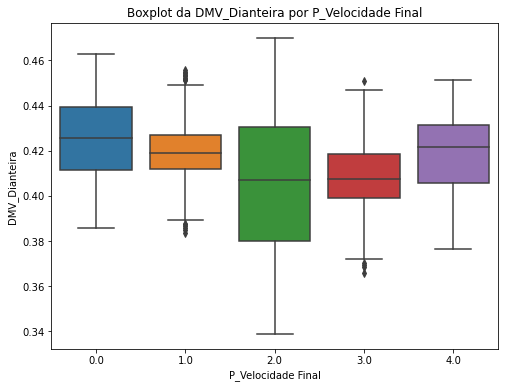

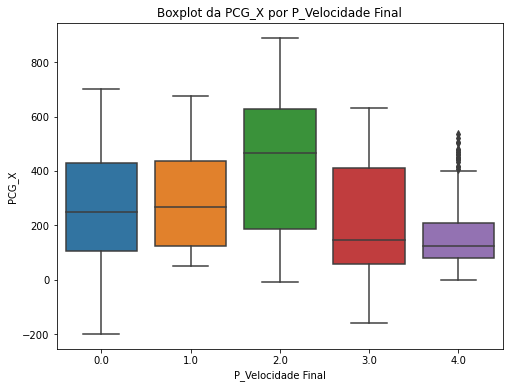

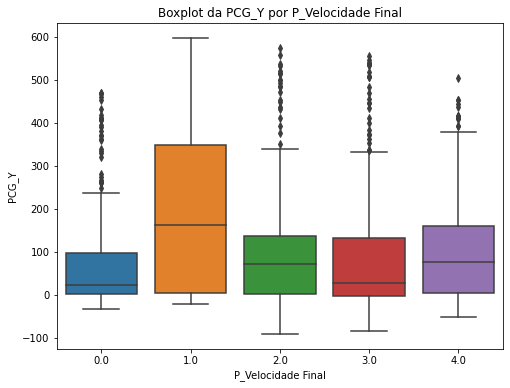

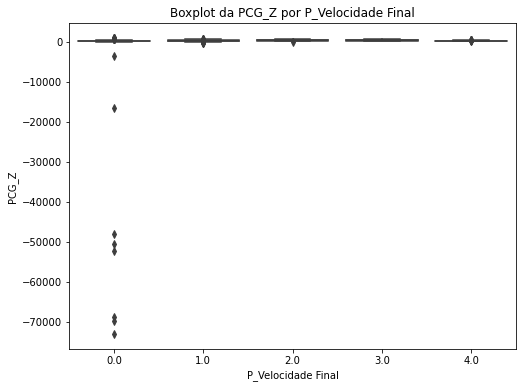

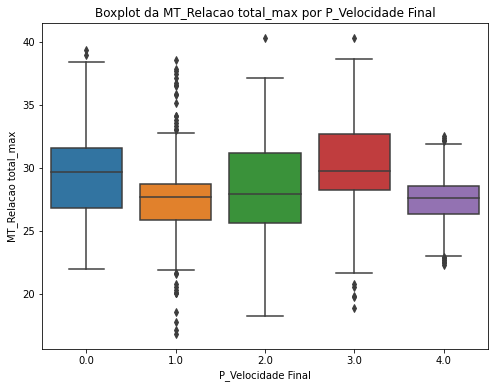

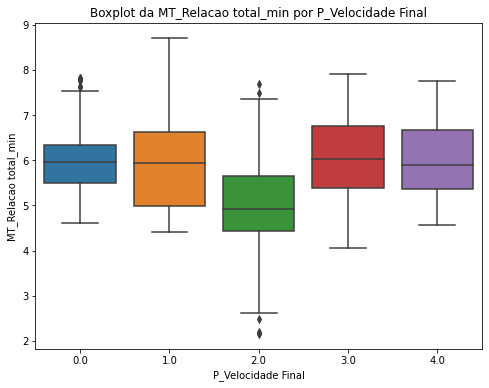

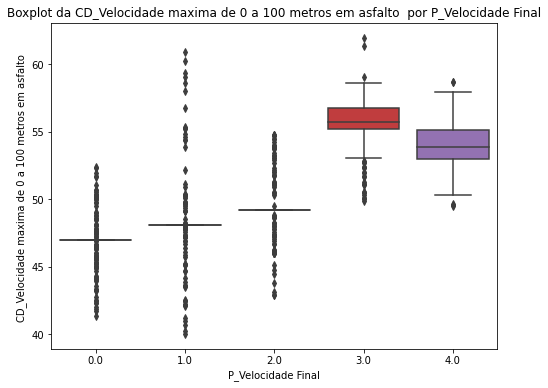

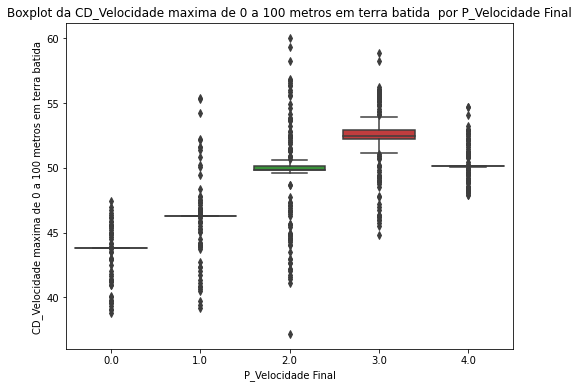

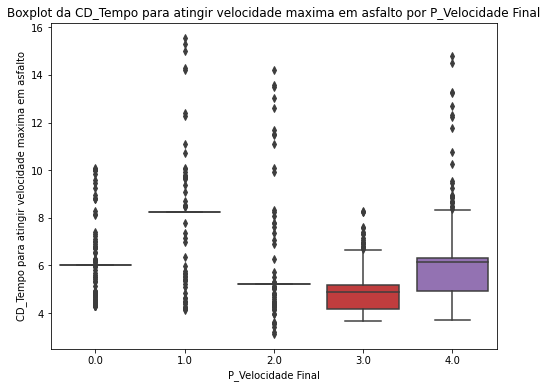

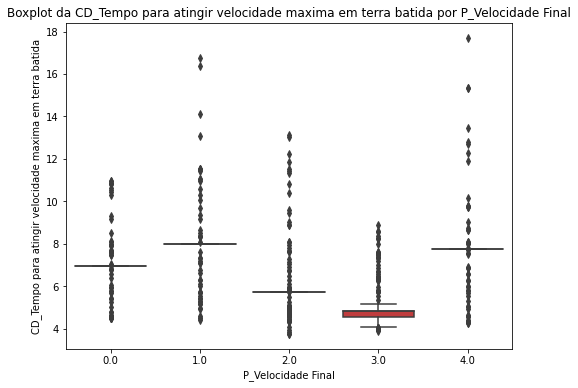

In [16]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Velocidade Final':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Velocidade Final', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Velocidade Final')
        plt.ylabel(coluna)
        plt.xlabel('P_Velocidade Final')
        plt.show()

In [17]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [18]:
data_corr = df.drop(['P_Velocidade Final'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

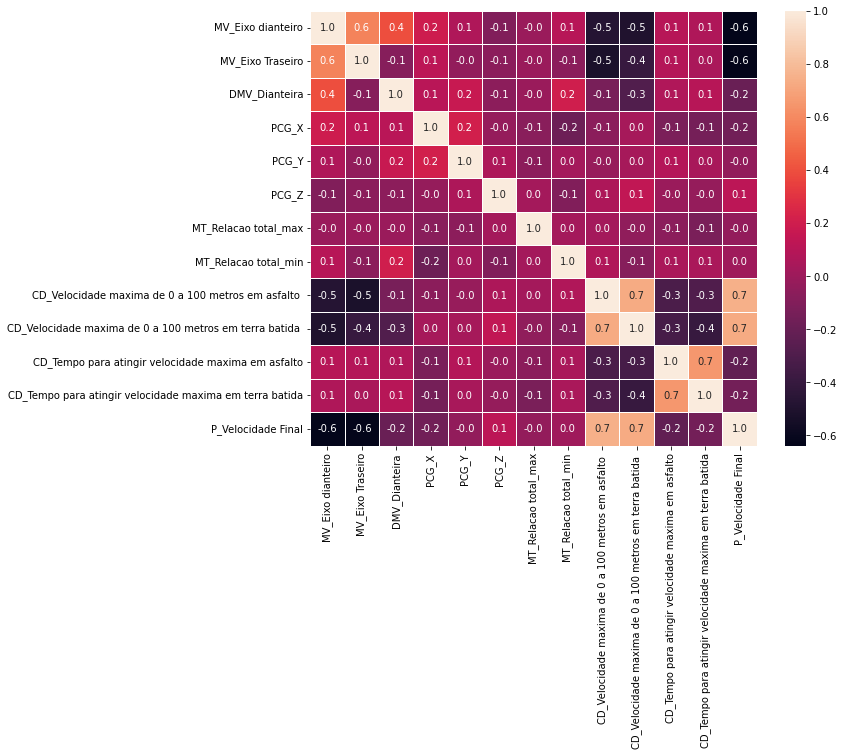

In [19]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [20]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 0

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

          Massa  DMV_Dianteira       PCG_X      PCG_Y         PCG_Z  \
0     13.934866       0.445369  485.153288 -19.827850 -68764.325890   
1     11.799052       0.400038  263.935693   7.110928    251.177947   
2     26.736423       0.417494    9.740746   1.319692    185.975386   
3     20.426084       0.447466  217.672428 -20.970397    126.250912   
4     40.598083       0.443812  201.426690  22.438382    -27.267006   
...         ...            ...         ...        ...           ...   
992   -9.915878       0.441930  478.355026  76.875337    192.501465   
995   -8.694211       0.412839   77.704667  76.875337    315.726447   
997  -21.599799       0.420964  134.416344  76.875337    358.939170   
998  -22.987366       0.434142  395.941259  76.875337    203.568774   
1000 -17.440537       0.432000  124.998649  76.875337    189.600000   

      MT_Relacao total_max  MT_Relacao total_min  \
0                25.470433              7.040260   
1                29.636217              6.3

In [21]:
# Aplicar PCA para reduzir variáveis de alta correlação - Velocidade maxima de 0 a 100 metros
variaveis_reduzidas = df[['CD_Velocidade maxima de 0 a 100 metros em asfalto ', 'CD_Velocidade maxima de 0 a 100 metros em terra batida ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 7

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Velocidade maxima de 0 a 100 metros', variavel_reduzida)

print(df)

          Massa  DMV_Dianteira       PCG_X      PCG_Y         PCG_Z  \
0     13.934866       0.445369  485.153288 -19.827850 -68764.325890   
1     11.799052       0.400038  263.935693   7.110928    251.177947   
2     26.736423       0.417494    9.740746   1.319692    185.975386   
3     20.426084       0.447466  217.672428 -20.970397    126.250912   
4     40.598083       0.443812  201.426690  22.438382    -27.267006   
...         ...            ...         ...        ...           ...   
992   -9.915878       0.441930  478.355026  76.875337    192.501465   
995   -8.694211       0.412839   77.704667  76.875337    315.726447   
997  -21.599799       0.420964  134.416344  76.875337    358.939170   
998  -22.987366       0.434142  395.941259  76.875337    203.568774   
1000 -17.440537       0.432000  124.998649  76.875337    189.600000   

      MT_Relacao total_max  MT_Relacao total_min  \
0                25.470433              7.040260   
1                29.636217              6.3

In [22]:
# Aplicar PCA para reduzir variáveis de alta correlação - Tempo para atingir velocidade maxima
variaveis_reduzidas = df[['CD_Tempo para atingir velocidade maxima em asfalto', 'CD_Tempo para atingir velocidade maxima em terra batida']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 8

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Tempo para atingir velocidade maxima', variavel_reduzida)

print(df)

          Massa  DMV_Dianteira       PCG_X      PCG_Y         PCG_Z  \
0     13.934866       0.445369  485.153288 -19.827850 -68764.325890   
1     11.799052       0.400038  263.935693   7.110928    251.177947   
2     26.736423       0.417494    9.740746   1.319692    185.975386   
3     20.426084       0.447466  217.672428 -20.970397    126.250912   
4     40.598083       0.443812  201.426690  22.438382    -27.267006   
...         ...            ...         ...        ...           ...   
992   -9.915878       0.441930  478.355026  76.875337    192.501465   
995   -8.694211       0.412839   77.704667  76.875337    315.726447   
997  -21.599799       0.420964  134.416344  76.875337    358.939170   
998  -22.987366       0.434142  395.941259  76.875337    203.568774   
1000 -17.440537       0.432000  124.998649  76.875337    189.600000   

      MT_Relacao total_max  MT_Relacao total_min  \
0                25.470433              7.040260   
1                29.636217              6.3

In [23]:
# Remova a última linha do DataFrame e armazene-a em uma variável separada
dados_MB24 = df.iloc[-1]
df = df.iloc[:-1]

dados_MB24 = dados_MB24.drop('P_Velocidade Final')

# Converta a série em um DataFrame com uma única linha
dados_MB24 = dados_MB24.to_frame().T

print(dados_MB24)

          Massa  DMV_Dianteira       PCG_X      PCG_Y  PCG_Z  \
1000 -17.440537          0.432  124.998649  76.875337  189.6   

      MT_Relacao total_max  MT_Relacao total_min  \
1000              27.58357              5.897655   

      CD_Velocidade maxima de 0 a 100 metros  \
1000                                 3.59268   

      CD_Tempo para atingir velocidade maxima  
1000                                 -3.07697  


## Balanceamento de Classes

In [24]:
# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [25]:
# Verificar o balanceamento original
print('Contagem de classes antes do SMOTE:', Counter(Y))

Contagem de classes antes do SMOTE: Counter({0.0: 200, 1.0: 200, 2.0: 200, 3.0: 200, 4.0: 153})


In [26]:
# Aplicar SMOTE ao conjunto inteiro
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, Y = smote.fit_resample(X, Y)

In [27]:
# Verificar a contagem de classes após o SMOTE
print('Contagem de classes após o SMOTE:', Counter(Y))

Contagem de classes após o SMOTE: Counter({0.0: 200, 1.0: 200, 2.0: 200, 3.0: 200, 4.0: 200})


In [28]:
# Junte X e Y em um único DataFrame
df = pd.concat([X, Y], axis=1)
print(df)

         Massa  DMV_Dianteira       PCG_X       PCG_Y         PCG_Z  \
0    13.934866       0.445369  485.153288  -19.827850 -68764.325890   
1    11.799052       0.400038  263.935693    7.110928    251.177947   
2    26.736423       0.417494    9.740746    1.319692    185.975386   
3    20.426084       0.447466  217.672428  -20.970397    126.250912   
4    40.598083       0.443812  201.426690   22.438382    -27.267006   
..         ...            ...         ...         ...           ...   
995 -13.478072       0.440528  442.056928   56.512678    220.830908   
996 -20.661818       0.445155  509.427394  354.602612    213.656002   
997 -18.456027       0.416845  111.564594   73.031781    224.415183   
998 -15.349728       0.399306  111.707837    5.293779    159.625074   
999 -10.848676       0.412892   91.329642    4.758654    214.968076   

     MT_Relacao total_max  MT_Relacao total_min  \
0               25.470433              7.040260   
1               29.636217              6.3464

In [29]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_treino)

         Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
676  -2.826802       0.398536   69.335565   -0.138267  151.619650   
818  -4.946330       0.411330   62.994871    7.055069  184.279999   
576   4.689454       0.436862  316.676420   67.935255  272.712242   
136   5.854355       0.425521   82.218984   -5.244016   58.129969   
591  -4.163908       0.448589  475.063285  482.785242  350.726716   
..         ...            ...         ...         ...         ...   
285   6.288361       0.451632  353.107200  421.127653  314.623390   
736   3.074122       0.385577  596.322846  -24.064174  489.156526   
725 -11.363394       0.407679 -149.325962    5.265252  591.361554   
573   1.768873       0.437522  478.285605   49.504193  266.760666   
490  22.987260       0.428587  600.951704   73.786807  350.726716   

     MT_Relacao total_max  MT_Relacao total_min  \
676             35.985706              5.823699   
818             30.070000              6.940000   
576             27

In [30]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Treino\\dadostreino_vel.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
dados_treino.to_excel(caminho_arquivo, sheet_name='P_Velocidade', index=False)

In [31]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Teste\\dadosteste_vel.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
dados_teste.to_excel(caminho_arquivo, sheet_name='P_Velocidade', index=False)

# Pré-seleção do Modelo

## Árvore de Decisão de Classificação

In [32]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

## Classificação de Floresta Aleatória

In [33]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

## Extreme Gradient Boosting

In [34]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Refinamento do Modelo

## Árvore de Decisão de Classificação

In [35]:
# Exemplo de Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Avaliar a qualidade da divisão
    'max_depth': [None, 5, 10, 15],          # Profundidade máxima das árvores 
    'min_samples_split': [2, 5, 10],         # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de amostras em uma folha
    'max_features': [None, 'sqrt', 'log2']   # Número máximo de recursos a serem considerados em cada divisão
}
grid_search = GridSearchCV(estimator=model_DTC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [36]:
# Ajustar um modelo de Árvore de Decisão
model_DTC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_DTC.set_params(**best_params)

DecisionTreeClassifier(max_depth=10)

## Classificação de Floresta Aleatória

In [37]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt']        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidPara

In [ ]:
# Guardar os parâmetros encontrados fora do código
#melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
#joblib.dump(melhores_parametros, 'melhores_parametros_acel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_acel.pkl')

In [38]:
# Ajustar um modelo de Floresta Aleatória
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params)

RandomForestClassifier(max_depth=10, n_estimators=30)

## Extreme Gradient Boosting

In [39]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árvores na floresta
    'max_depth': [3, 4, 5],                # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],          # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],          # Fração de amostras usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],        # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],                # Regularização gamma (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [40]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Validação Cruzada

In [41]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Árvore de Decisão de Classificação

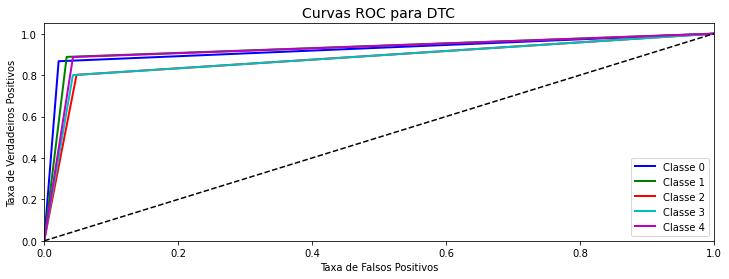

In [42]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_DTC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para DTC', fontsize=14)
plt.show()

In [43]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_DTC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 85.86%
Intervalo de acurácia: [81.39% ~ 90.32%]


In [44]:
# Relatório do modelo
Y_pred = model_DTC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.9123    0.9123    0.9123        57
         1.0     0.8529    0.8788    0.8657        66
         2.0     0.7797    0.7797    0.7797        59
         3.0     0.9107    0.8500    0.8793        60
         4.0     0.9167    0.9483    0.9322        58

    accuracy                         0.8733       300
   macro avg     0.8745    0.8738    0.8738       300
weighted avg     0.8737    0.8733    0.8732       300



## Classificação de Floresta Aleatória

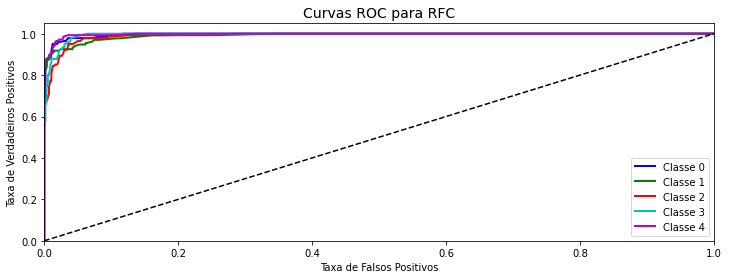

In [45]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para RFC', fontsize=14)
plt.show()

In [46]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 91.43%
Intervalo de acurácia: [87.10% ~ 95.76%]


In [47]:
# Relatório do modelo
Y_pred = model_RFC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.9180    0.9825    0.9492        57
         1.0     0.9254    0.9394    0.9323        66
         2.0     0.9138    0.8983    0.9060        59
         3.0     0.9483    0.9167    0.9322        60
         4.0     1.0000    0.9655    0.9825        58

    accuracy                         0.9400       300
   macro avg     0.9411    0.9405    0.9404       300
weighted avg     0.9407    0.9400    0.9400       300



## Extreme Gradient Boosting

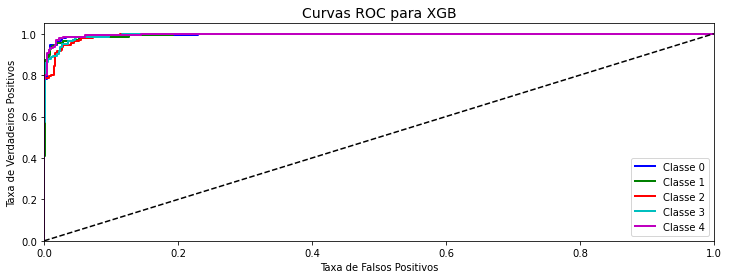

In [48]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para XGB', fontsize=14)
plt.show()

In [49]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 92.57%
Intervalo de acurácia: [88.67% ~ 96.47%]


In [50]:
# Relatório do modelo
Y_pred = model_XGB.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.9643    0.9474    0.9558        57
         1.0     0.9143    0.9697    0.9412        66
         2.0     0.9655    0.9492    0.9573        59
         3.0     0.9667    0.9667    0.9667        60
         4.0     1.0000    0.9655    0.9825        58

    accuracy                         0.9600       300
   macro avg     0.9622    0.9597    0.9607       300
weighted avg     0.9609    0.9600    0.9602       300



# Desempate

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento

In [51]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Avaliação

In [52]:
# Fazer previsões no conjunto de teste
Y_pred = model_XGB.predict(X_teste)

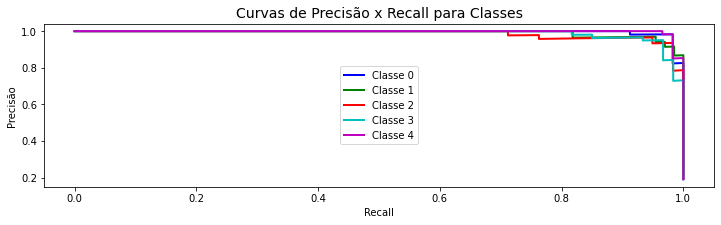

In [53]:
# Comparar scores de Previsão e Recall
# Converta Y_teste para uma matriz binária de classes
Y_bin = label_binarize(Y_teste, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = model_XGB.predict_proba(X_teste)

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

In [54]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
Y_pred = model_XGB.predict(X_teste)

# Calcule a acurácia
accuracy = accuracy_score(Y_teste, Y_pred)

print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Acurácia no conjunto de teste: 0.95


## Análise de Variáveis 

In [55]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.1753271  0.04341722 0.06763513 0.04624716 0.07711773 0.05622314
 0.04740946 0.24379489 0.24282815]


[21:11:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 1473/1500 [00:27<00:00]        

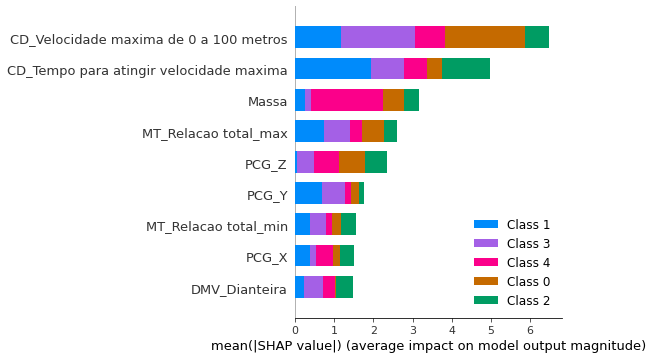

In [56]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Predição

In [57]:
# Valor único para fazer a previsão
X_prev = dados_MB24

# Faça a previsão
previsao = model_XGB.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')

A previsão para X_prev é: 4.00
